# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activation, batch, optimizers)
### LECTURE: The "wine quality" dataset
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt

# Import and process the data

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url, sep = ';')
data = data[data['total sulfur dioxide'] < 200] # drop a few outliers

# z-score all columns except quality
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
cols2zscore

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

# Re-organize the data: train/test in DataLoaders

In [3]:
# convert from pandas dataframe to tensor

# drop residual sugar
cols2zscore = cols2zscore.drop('residual sugar')

dataT = torch.tensor(data[cols2zscore].values).float()
sugar = torch.tensor(data['residual sugar'].values).float()
sugar = sugar[:, None]

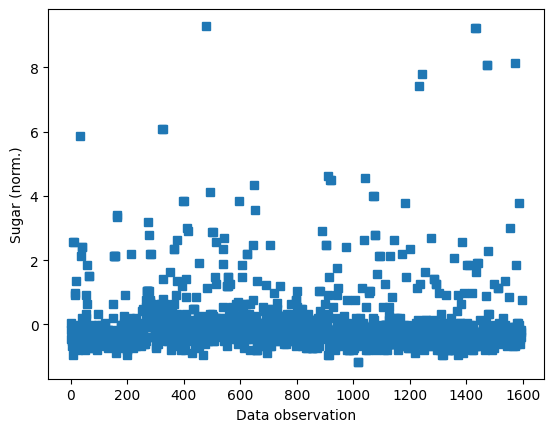

In [4]:
# check values in sugar
plt.plot(sugar, 's')
plt.xlabel('Data observation')
plt.ylabel('Sugar (norm.)')
plt.show()

In [5]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, sugar, test_size = 0.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
test_dataset  = torch.utils.data.TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_dataset, batch_size = batchsize, shuffle = True, drop_last = True)
test_loader  = DataLoader(test_dataset, batch_size = test_dataset.tensors[0].shape[0])


# Construct the model and training plans

In [6]:
# a function that creates the ANN model
class ANNWine(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(11, 16)

    self.fc1 = nn.Linear(16, 32)
    self.fc2 = nn.Linear(32, 32)

    self.output = nn.Linear(32, 1)

  def forward(self, x):
    x = F.relu(self.input(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.output(x)


In [7]:
# train the model

# global parameter
numepochs = 1000

def trainTheModel():

  lossfun = nn.MSELoss()
  optimizer = torch.optim.SGD(winenet.parameters(), lr = 0.01)

  # initialize accuracies as empties
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    winenet.train()

    # loop over training data batches
    batchLoss = []
    for X, y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    trainLoss[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X, y = next(iter(test_loader)) # extract X,y from test dataloader

    with torch.no_grad():
      yHat = winenet(X)

    testLoss[epochi] = lossfun(yHat, y).item()

  # function output
  return trainLoss, testLoss

# Test it out

In [8]:
winenet = ANNWine()
trainLoss, testLoss = trainTheModel()

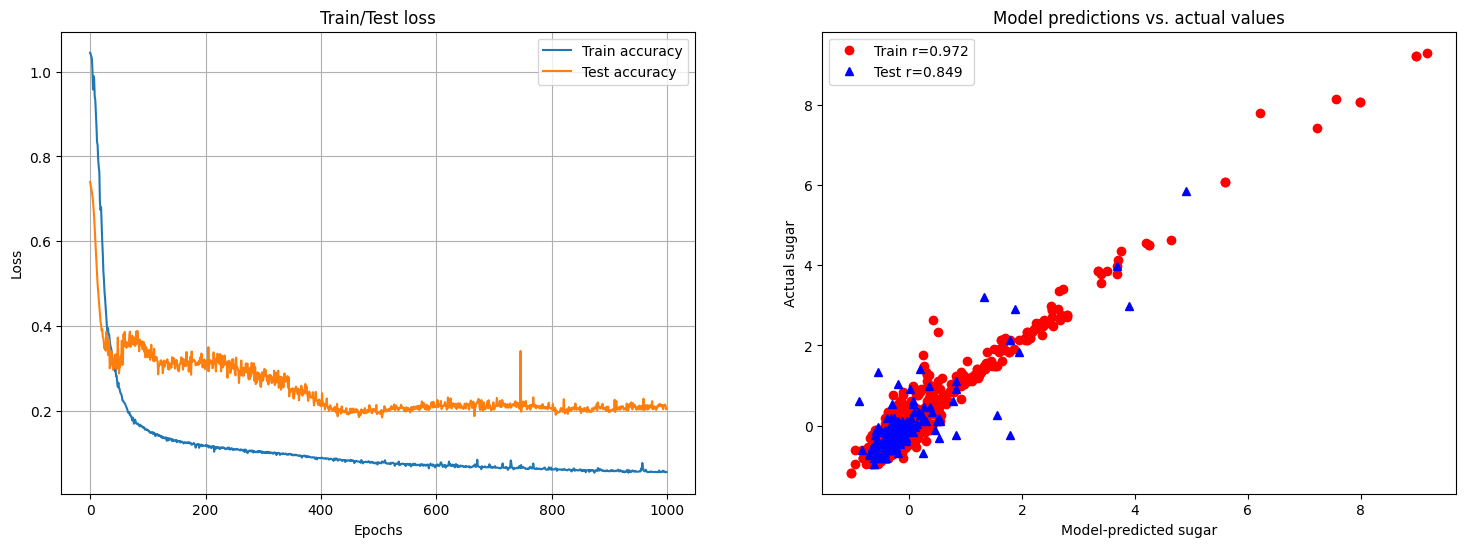

In [9]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize = (18, 6))

ax[0].plot(trainLoss, label = 'Train accuracy')
ax[0].plot(testLoss, label = 'Test accuracy')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()

# show predictions and real values
yHatTrain = winenet(train_data)
yHatTest  = winenet(test_data)

ax[1].plot(yHatTrain.detach(), train_labels, 'ro')
ax[1].plot(yHatTest.detach(), test_labels, 'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('Actual sugar')
ax[1].set_title('Model predictions vs. actual values')

# correlations between predicted and actual values
corrTrain = np.corrcoef(yHatTrain.detach().T, train_labels.T)[1, 0]
corrTest = np.corrcoef(yHatTest.detach().T, test_labels.T)[1, 0]
ax[1].legend([f'Train r={corrTrain:.3f}', f'Test r={corrTest:.3f}'])

plt.show()

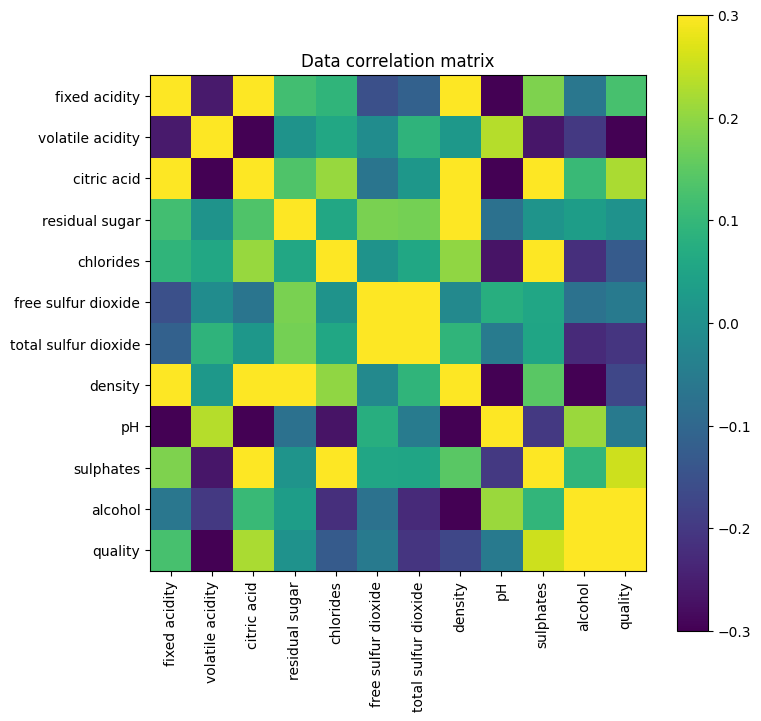

In [10]:
# Inspect the correlation matrix
fig = plt.figure(figsize=(8,8))

plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data.keys())),labels=data.keys(),rotation=90)
plt.yticks(range(len(data.keys())),labels=data.keys())
plt.colorbar()
plt.title('Data correlation matrix')
plt.show()